# Signal Processing Notebook

This notebook demonstrates some DaViTPy tools for working with timeseries data.  It includes filtering and visualization tools.

The DaViTPy signal is used by creating a VTSig object, which includes built-in methods for keeping track of all steps in a signal processing algorithm.  As the signal is processed, all preceeding variants of the signal are saved within the object and a history is created.  This makes it very easy to see what has been done with the data at any step along the way.

Written by N.A. Frissell, 9 July 2013.



In [1]:
#Import the modules we need.
%pylab inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as mp
import datetime
import copy

from davitpy import pydarn
from davitpy import utils
import davitpy.pydarn.proc.signal as signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
#This cell just sets some preferences to make the plots look nice.
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

figure = {'figsize' : '15, 12',
          'dpi'     : 600}
matplotlib.rc('figure', **figure)

# Signal Processing Example - GOES10 Data

We will start with some GOES10 magnetometer data since it is regularly sampled and easy to load from the provided sample data file.

## Set Global Metadata

In [3]:
#Metadata is used to control aspects of signal processing and plotting throughout the routine, as well as a way
#of keeping track of different data properties and processing done to the data.

#Global metadata will control parameters pertaining to all signals being worked on.
#Here, we define the time period we want any processing we do to apply to.
signal.globalMetaData_add(validTimes = [datetime.datetime(2008,07,14,16,00), datetime.datetime(2008,07,15,00,00)])

## Load Data

In [4]:
#Read data from file and sort out variables.
satfile = 'signal-sample_data-goes10.txt'
dataIn  = np.genfromtxt(satfile,comments='#',usecols=(0,1,2),dtype=[('date','S10'),('time','S5'),('btot','f8')])
timeStr = map(' '.join, zip(dataIn['date'],dataIn['time']))
datetimeObjList = [ datetime.datetime.strptime(x,'%Y-%m-%d %H:%M') for x in timeStr ]

Next we instantiate vt sig object.  All you need is a list of Python datetime.datetime objects and the corresponding data.

* The goes10 object will have a number of subobjects and methods.
* goes10.raw is subobject that contains the raw data of datetimeObjList,data.
* goes10.active should always point to the most processed version of the data, unless you manually set it to point to something else.
* When you apply a processing algorthim to the goes10 object, it will use the "active" dataset, unless you specify otherwise. 

In [5]:
#Instantiate vt sig object
goes10 = signal.sig(datetimeObjList,dataIn['btot'])

In [6]:
#Now lets look to see where the data is actually stored...
goes10.raw.dtv #Datetime vector (dtv)

array([datetime.datetime(2008, 7, 14, 0, 0),
       datetime.datetime(2008, 7, 14, 0, 1),
       datetime.datetime(2008, 7, 14, 0, 2), ...,
       datetime.datetime(2008, 7, 14, 23, 57),
       datetime.datetime(2008, 7, 14, 23, 58),
       datetime.datetime(2008, 7, 14, 23, 59)], dtype=object)

In [7]:
goes10.raw.data #Data vector

array([  98.42,   98.92,  100.2 , ...,  103.  ,  103.07,  102.98])

Now we set the object metadata.  This not only allows you to keep track of information about the date, but is also used by the plotting and signal processing routines.

goes10.metadata applies to all versions of the signal stored in the goes10 object.  goes10.[dataSetName].metadata applies just to that data set.  Anything set in goes10.[dataSetName].metadata will always override anything set in goes10.metadata.  You can use the goes10.[dataSetName].getAllMetaData() method to see what metadata is actually being applied to a particular dataset.

In [8]:
goes10.metadata['title'] = 'GOES 10'
goes10.metadata['ylabel'] = 'B$_{tot}$ [nT]'
goes10.metadata['xlabel'] = 'Time [UT]\n14 July 2008'
#goes10.metadata['xmin'] = datetime.datetime(2008,07,14,18,00)
#goes10.metadata['xmax']  = datetime.datetime(2008,07,15,00,00)
#goes10.raw.metadata['ymin'] = 100.
#goes10.raw.metadata['ymax'] = 125.

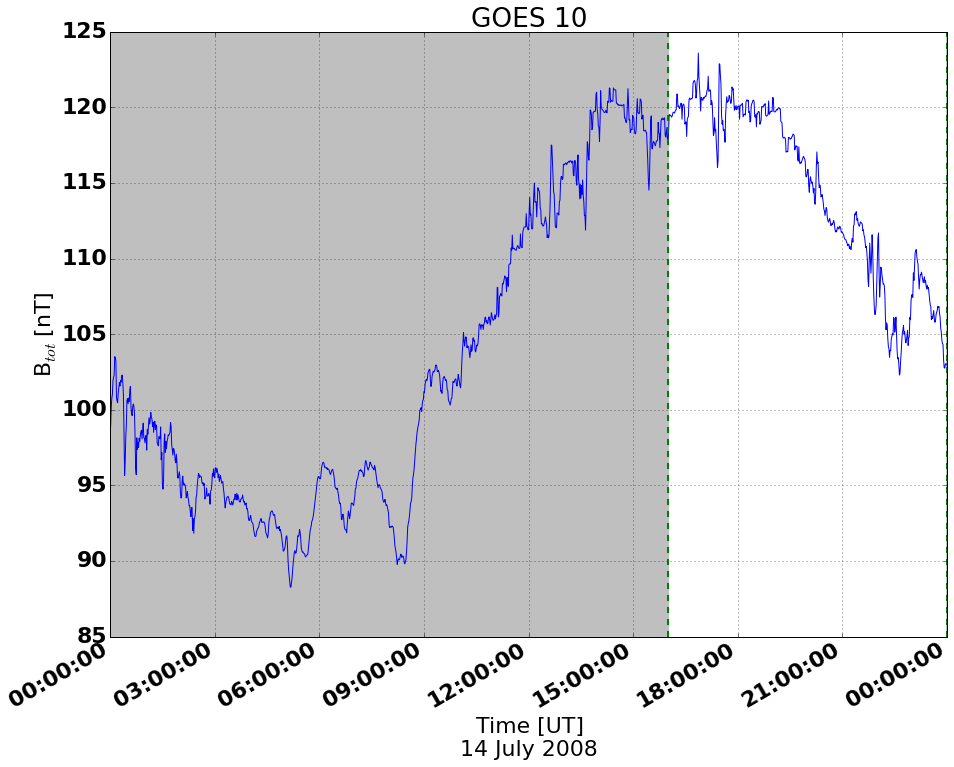

In [9]:
#Now let's plot our raw data.  This plot shows all of the GOES10 data which has been loaded into the object.
#The white region is the region defined by the validTimes in the global metadata.
goes10.raw.plot()

## Process Data

Let's run some processing now. Remember, each step does not discard the data from the previous steps.

In [10]:
#Apply a linear detrend through the data.
signal.detrend(goes10.raw)

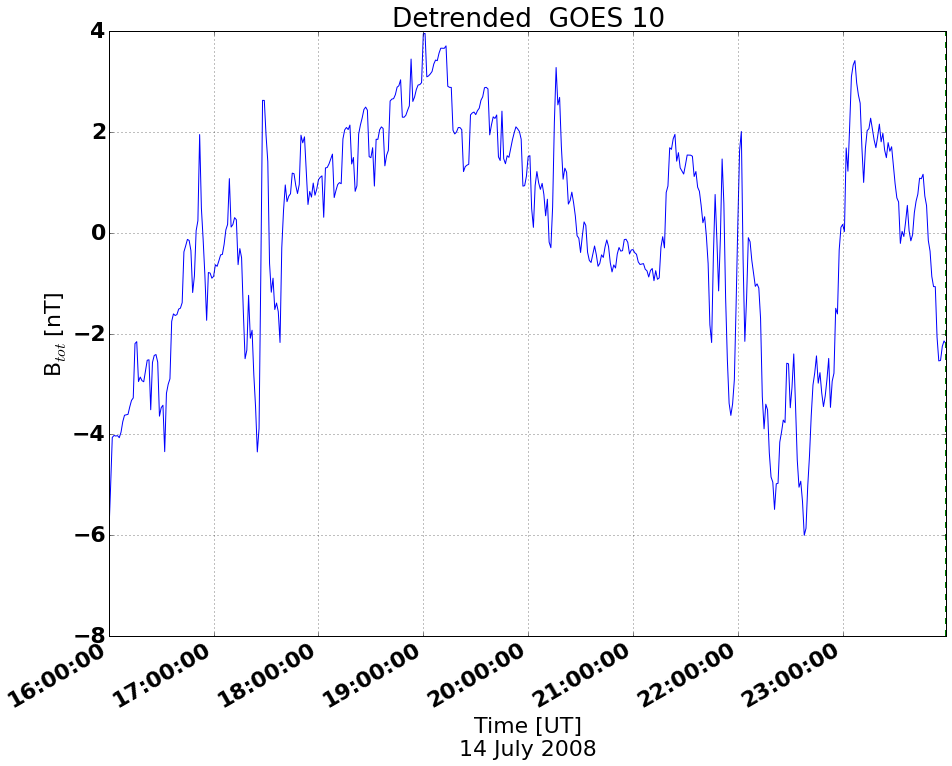

In [11]:
#Here is the result of the detrending.  Note that only the validTimes period is shown now.  This is because
#the detrending was applied only to the validTimes period.
goes10.detrended.plot()

In [12]:
#Global metadata can also be used to define characteristics of a filter.
signal.globalMetaData_add(filter_numtaps = 101) #This is the length of the filter.  A larger number is a better filter, but slower computationally.
signal.globalMetaData_add(filter_cutoff_high  = 0.004) #Frequencies are in Hz.
signal.globalMetaData_add(filter_cutoff_low  = 0.001)

In [13]:
#Now filter the data with filter we defined in the global metadata.
goes10Filt = signal.filter(goes10)

In [14]:
#Let's look at the current history of our signal object.
goes10.active.history

{datetime.datetime(2015, 3, 12, 1, 59, 48, 601049): 'Signal Object Created',
 datetime.datetime(2015, 3, 12, 1, 59, 53, 716269): 'Truncate: 2008JUL14 16:00 UT - 2008JUL15 00:00 UT',
 datetime.datetime(2015, 3, 12, 1, 59, 53, 754184): 'Linear detrend (scipy.signal.detrend)',
 datetime.datetime(2015, 3, 12, 1, 59, 55, 376582): 'Filter: blackman, Nyquist: 0.00833333333333 Hz, Cuttoff: [0.001, 0.004] Hz'}

In [15]:
#We can also see all of the metadata set for a particular dataObject.
goes10.active.getAllMetaData()

{'fft_xlabel': 'Frequency [Hz]',
 'fft_ylabel': 'FFT Spectrum Magnitude',
 'filter_cutoff_high': 0.004,
 'filter_cutoff_low': 0.001,
 'filter_numtaps': 101,
 'title': 'Filtered Detrended  GOES 10',
 'validTimes': [datetime.datetime(2008, 7, 14, 16, 50),
  datetime.datetime(2008, 7, 14, 23, 10)],
 'xlabel': 'Time [UT]\n14 July 2008',
 'ylabel': 'B$_{tot}$ [nT]'}

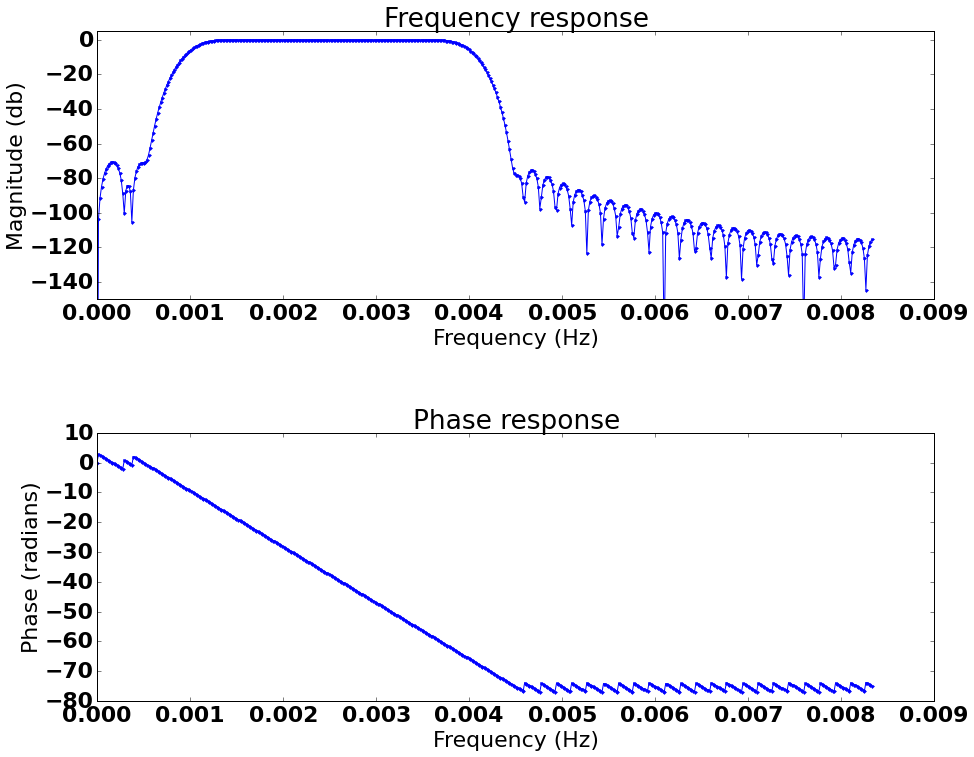

In [16]:
#Let's see the transfer function of the filter we used.
goes10Filt.plotTransferFunction()

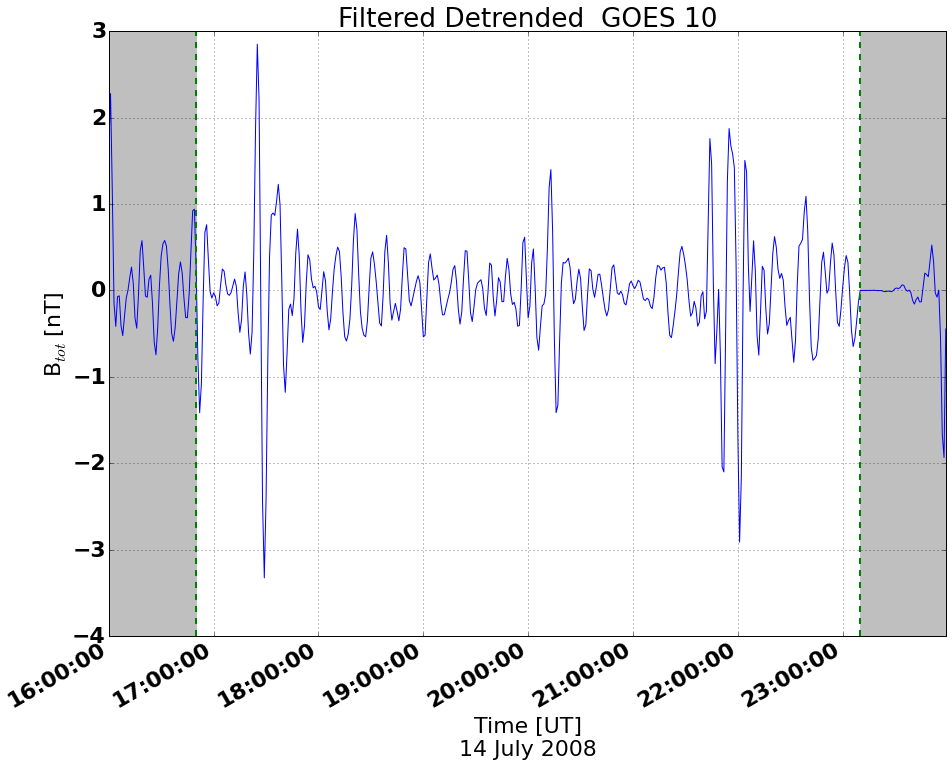

In [17]:
#And now the filtered result.  Because the filter causes a delay in the signal and doesn't get to the end of
#the signal, part of the filtered signal should be discard.  Appropriate new validTimes have been set, and the
#gray bars at the beginning and end mark the part of the signal to be discarded.

#Note that the validTimes here only apply to this filtered signal (goes10.filtered.metadata['validTimes']), and
#not the global metadata.  When multiple validTimes are in place for a particular object, the most restrictive set of
#validTimes is always used.
goes10.filtered.plot()

/usr/local/lib/python2.7/dist-packages/davitpy-0.2-py2.7-linux-x86_64.egg/davitpy/pydarn/proc/signal/signal.py:160: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if dtv == None: dtv = self.dtv


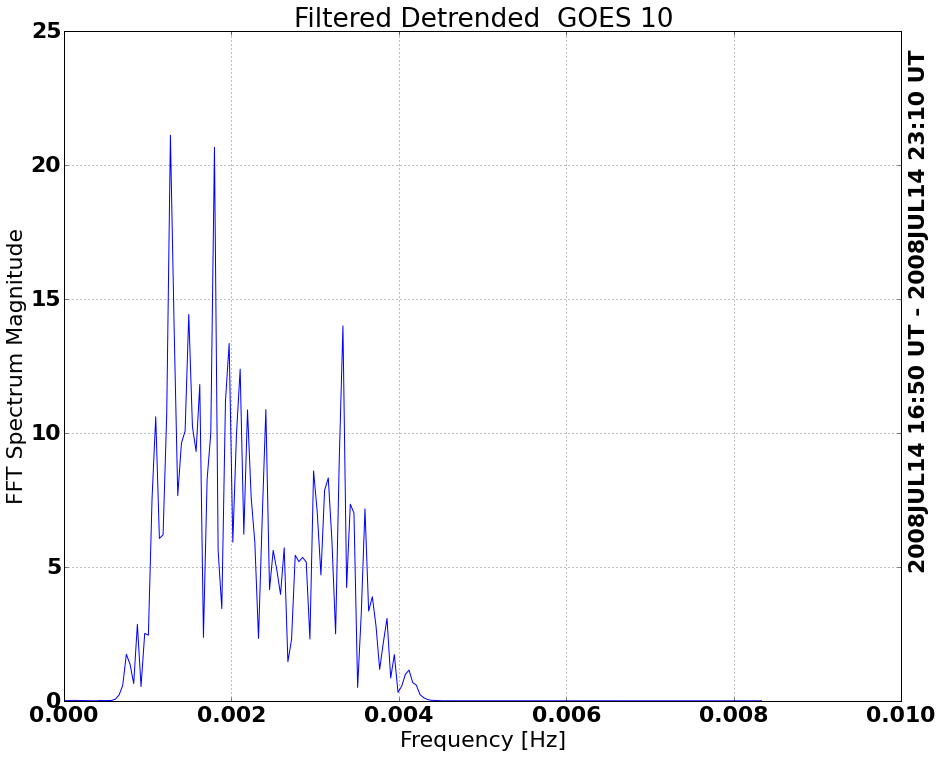

In [18]:
#We can also look at the spectrum of any signal that is regularly sampled in time.
goes10.filtered.plotfft()

In [19]:
#Once you plot the FFT (or invoke the fft() method), you now have access to the spectrum
goes10.filtered.freqVec #Here are the frequency bins in Hz.

array([ -8.33333333e-03,  -8.28947368e-03,  -8.24561404e-03,
        -8.20175439e-03,  -8.15789474e-03,  -8.11403509e-03,
        -8.07017544e-03,  -8.02631579e-03,  -7.98245614e-03,
        -7.93859649e-03,  -7.89473684e-03,  -7.85087719e-03,
        -7.80701754e-03,  -7.76315789e-03,  -7.71929825e-03,
        -7.67543860e-03,  -7.63157895e-03,  -7.58771930e-03,
        -7.54385965e-03,  -7.50000000e-03,  -7.45614035e-03,
        -7.41228070e-03,  -7.36842105e-03,  -7.32456140e-03,
        -7.28070175e-03,  -7.23684211e-03,  -7.19298246e-03,
        -7.14912281e-03,  -7.10526316e-03,  -7.06140351e-03,
        -7.01754386e-03,  -6.97368421e-03,  -6.92982456e-03,
        -6.88596491e-03,  -6.84210526e-03,  -6.79824561e-03,
        -6.75438596e-03,  -6.71052632e-03,  -6.66666667e-03,
        -6.62280702e-03,  -6.57894737e-03,  -6.53508772e-03,
        -6.49122807e-03,  -6.44736842e-03,  -6.40350877e-03,
        -6.35964912e-03,  -6.31578947e-03,  -6.27192982e-03,
        -6.22807018e-03,

In [20]:
goes10.filtered.spectrum #Here is the actual spectrum

array([ -7.76702755e-06 +2.54847505e-06j,
        -5.90275347e-06 -2.81282607e-06j,
        -5.36560407e-06 +2.65659080e-06j,
        -5.19584919e-06 -1.97506808e-06j,
        -8.42210569e-06 -6.46565482e-07j,
        -5.27510107e-06 +1.83602431e-06j,
        -7.89133924e-06 -3.79907448e-06j,
        -8.08425184e-06 +3.93443713e-06j,
        -4.81798088e-06 -2.09931369e-06j,
        -4.86121340e-06 -9.54500879e-07j,
        -8.67840453e-06 -2.31863988e-07j,
        -5.73122042e-06 -2.67375314e-07j,
        -1.04302766e-05 +8.14176941e-07j,
        -5.59987738e-06 -2.16149663e-06j,
        -3.01864589e-06 +6.63031931e-07j,
        -1.21224738e-05 -2.08722704e-06j,
        -5.98831825e-06 +5.68979111e-08j,
        -7.99450758e-06 -1.38322925e-06j,
        -6.81068830e-06 +2.69142231e-06j,
        -8.57678859e-06 -5.74709467e-06j,
        -8.19289545e-06 +1.20282212e-06j,
        -6.67270743e-06 -4.24091200e-07j,
        -1.13936169e-05 +4.83365571e-07j,
        -6.73647092e-06 -1.3169412

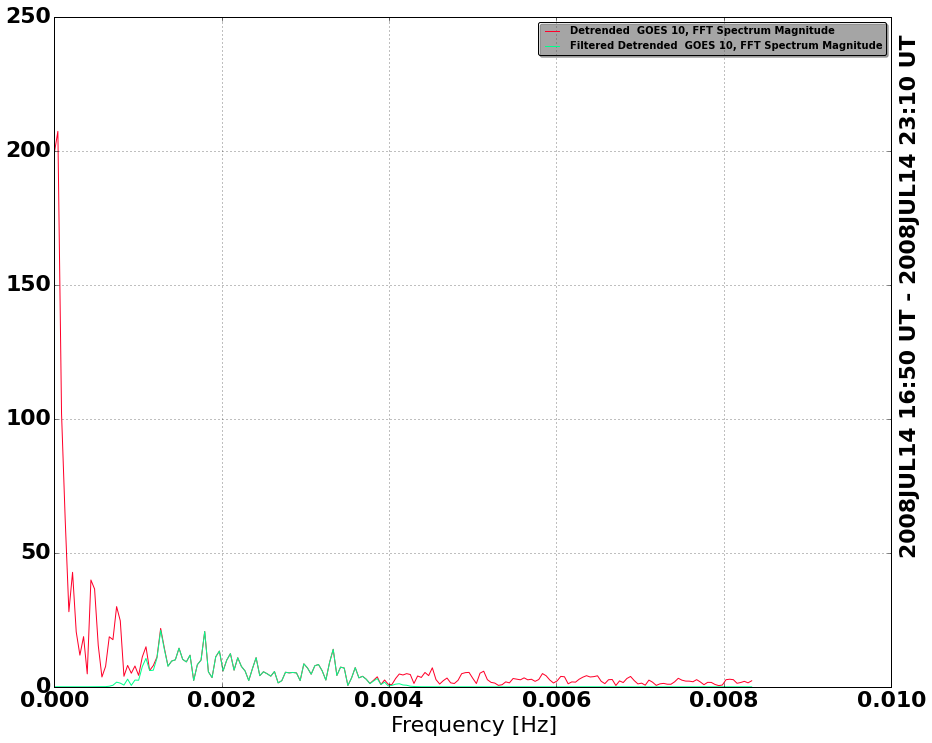

In [21]:
#We can also compare the spectra of two different signals.
a = signal.oplotfft([goes10.detrended,goes10.filtered])

# Signal Processing Example - SuperDARN Rankin Inlet Data

Now lets try looking at some SuperDARN data from the same period.  SuperDARN can be easily accessed through Virginia Tech's servers, as shown below.  Working with this data is a little trickier because it is not necessarily regularly sampled.

## Load Data

In [22]:
#Set some parameters regarding the event of interest.  Let's use a time series from beam 7, rangegate 0.
sTime = datetime.datetime(2008,7,14)
eTime = datetime.datetime(2008,7,14,23)
fileType = 'fitacf'
radar = 'rkn'
beam = 7
gate = 0

In [23]:
#Use this cell to load in data straight from DaViTPy.  See the radDataRead notebook for
#additional inspiration on reading SuperDARN data.
myPtr = pydarn.sdio.radDataOpen(sTime,radar,eTime=eTime,bmnum=beam,fileType=fileType)

datetimeObjList  = []
data = []
time_ii = copy.copy(sTime)
myBeam = 1
while time_ii < eTime:
    myBeam = pydarn.sdio.radDataReadRec(myPtr)
    if myBeam == None:
        break
    time_ii = myBeam.time
    if not gate in myBeam.fit.slist:
        continue
    
    datetimeObjList.append(time_ii)
    inx = int(np.where(np.array(myBeam.fit.slist) == gate)[0])
    data.append(myBeam.fit.v[inx])


Looking locally for fitacf files with radcode: rkn channel: None
found fitacf data in local files
Concatenating all the files in to one
cat /tmp/sd/20080714.0001.00.rkn.fitacf /tmp/sd/20080714.0201.00.rkn.fitacf /tmp/sd/20080714.0401.00.rkn.fitacf /tmp/sd/20080714.0601.00.rkn.fitacf /tmp/sd/20080714.0801.00.rkn.fitacf /tmp/sd/20080714.1001.00.rkn.fitacf /tmp/sd/20080714.1201.00.rkn.fitacf /tmp/sd/20080714.1401.00.rkn.fitacf /tmp/sd/20080714.1601.00.rkn.fitacf /tmp/sd/20080714.1800.12.rkn.fitacf /tmp/sd/20080714.2002.00.rkn.fitacf /tmp/sd/20080714.2202.00.rkn.fitacf > /tmp/sd/20080714.000000.20080714.230000.rkn.fitacf
rm /tmp/sd/20080714.0001.00.rkn.fitacf
rm /tmp/sd/20080714.0201.00.rkn.fitacf
rm /tmp/sd/20080714.0401.00.rkn.fitacf
rm /tmp/sd/20080714.0601.00.rkn.fitacf
rm /tmp/sd/20080714.0801.00.rkn.fitacf
rm /tmp/sd/20080714.1001.00.rkn.fitacf
rm /tmp/sd/20080714.1201.00.rkn.fitacf
rm /tmp/sd/20080714.1401.00.rkn.fitacf
rm /tmp/sd/20080714.1601.00.rkn.fitacf
rm /tmp/sd/20080714.180

In [24]:
#Instantiate vt sig object.
rkn = signal.sig(datetimeObjList,data)

In [25]:
#Set Rankin Inlet Radar Metadata.
rkn.metadata['title'] = ' '.join([radar.upper(),'Beam:',str(beam),'Gate:',str(gate)])
rkn.metadata['ylabel'] = 'Velocity [m/s]'
rkn.metadata['xlabel'] = 'Time [UT]\n14 July 2008'
#rkn.metadata['lineStyle'] = '.-'
#rkn.active.metadata['xmin'] = datetime.datetime(2008,07,14,20,30)
#rkn.active.metadata['xmax'] = datetime.datetime(2008,07,14,23,30)
#rkn.metadata['validTimes'] = [datetime.datetime(2008,07,14,01,00), datetime.datetime(2008,07,15,01,00)]

In [26]:
#Here is a way to change the valid times for the raw dataset.  Just uncomment the lines below and give it a try!
#valid = [rkn.raw.dtv[0], rkn.raw.dtv[-1]]
#rkn.raw.metadata['validTimes'] = valid

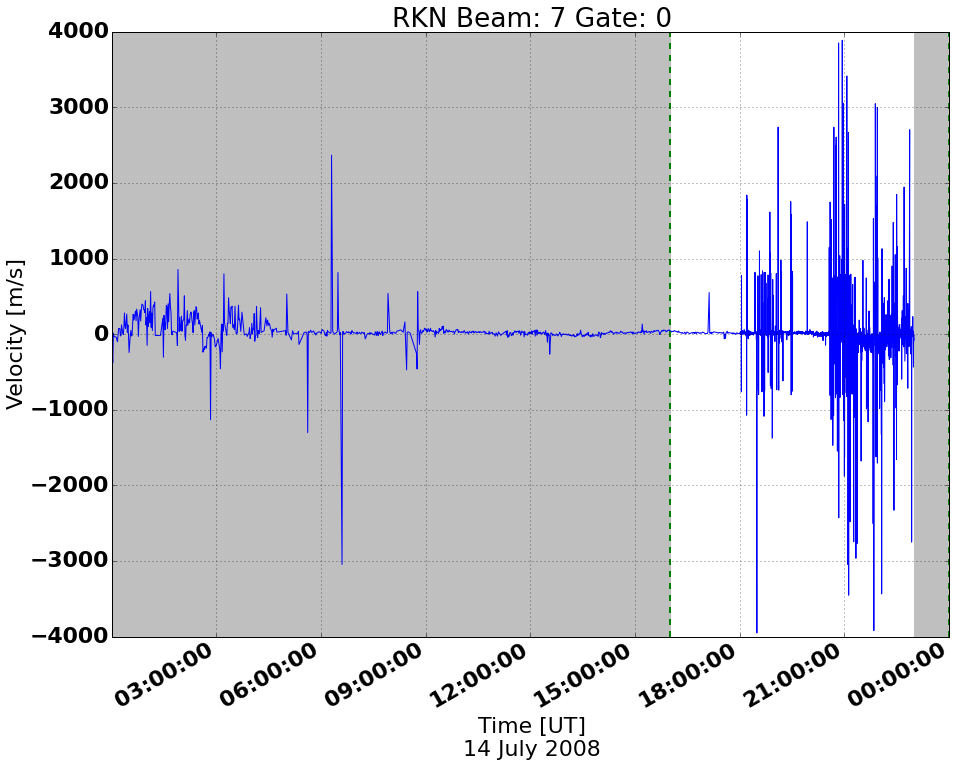

In [27]:
rkn.raw.plot()

In [28]:
#This method will tell us the sampling period of a dataset.
#If it is not regularly sampled, it will give us a warning.
rkn.raw.samplePeriod()

WARNING FOR "RKN Beam: 7 Gate: 0":
   Date time vector is not regularly sampled!
   Maximum difference in sampling rates is 657.003 sec.
   Using average sampling period of 97.774103 sec.


97.774103

In [29]:
#We can do a linear interpolation the signal to make it regularly sampled.
#This does need to be done with care... we will compare the raw and interpolated signal
#in the next cell.
signal.interpolate(rkn.raw,samplePeriod=3.)

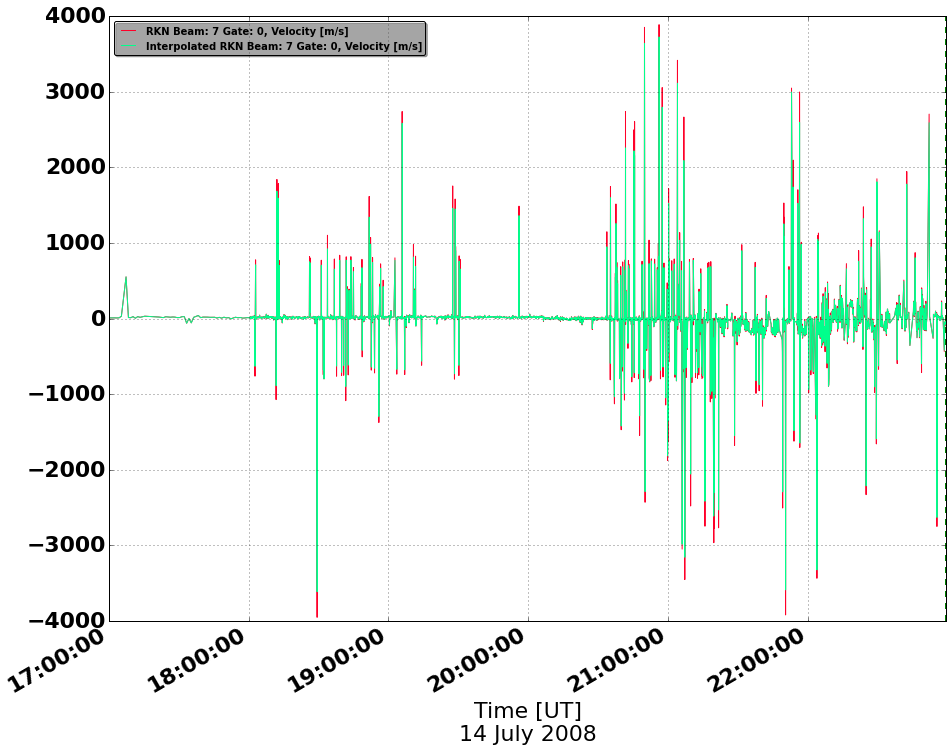

In [30]:
#Now compare the two signals.  You can see that the interpolated version misses parts of the raw signal.
signal.oplot([rkn.raw,rkn.active],xmin=datetime.datetime(2008,7,14,17))

In [31]:
#Again, detrending and filtering.  We are overriding the global metadata set before by using the numtaps keyword.
signal.detrend(rkn.active)
rknFilt = signal.filter(rkn.detrended,numtaps=1001)

In [32]:
#Print out some information about the filter being used.
rknFilt.comment

'Filter: blackman, Nyquist: 0.166666666667 Hz, Cuttoff: [0.001, 0.004] Hz'

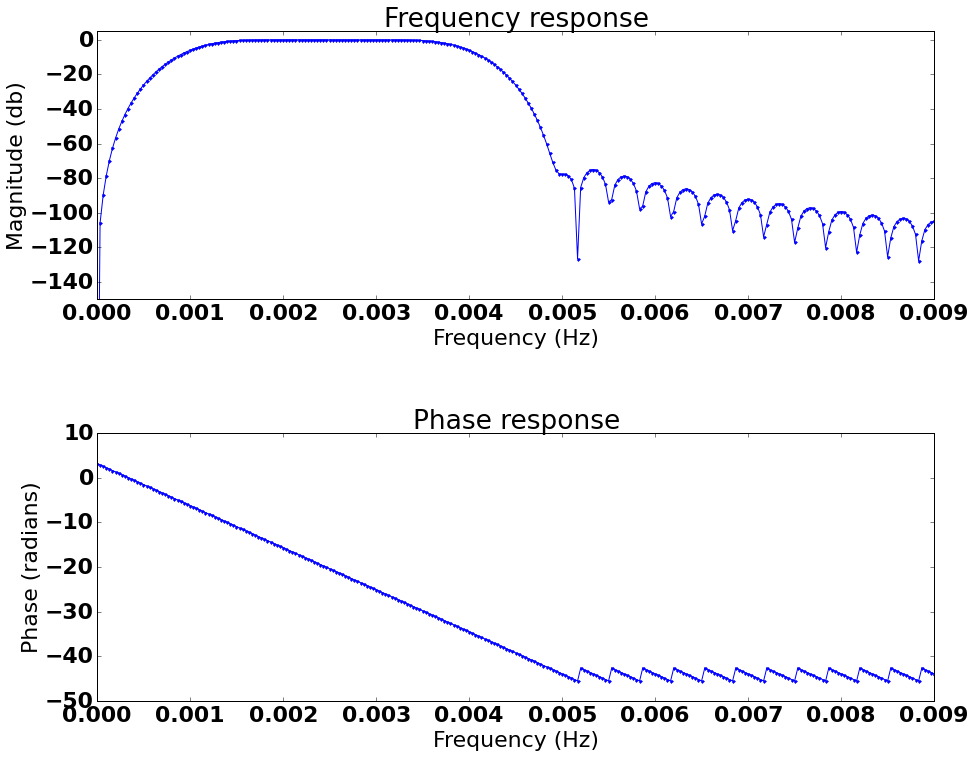

In [33]:
#Plot the transfer function.  The worN keyword computes the transfer function at a higher resolution than the
#default 512/(2*Pi).  See plotTransferFunction docstring for details.
rknFilt.plotTransferFunction(xmax=0.009,worN=5000)

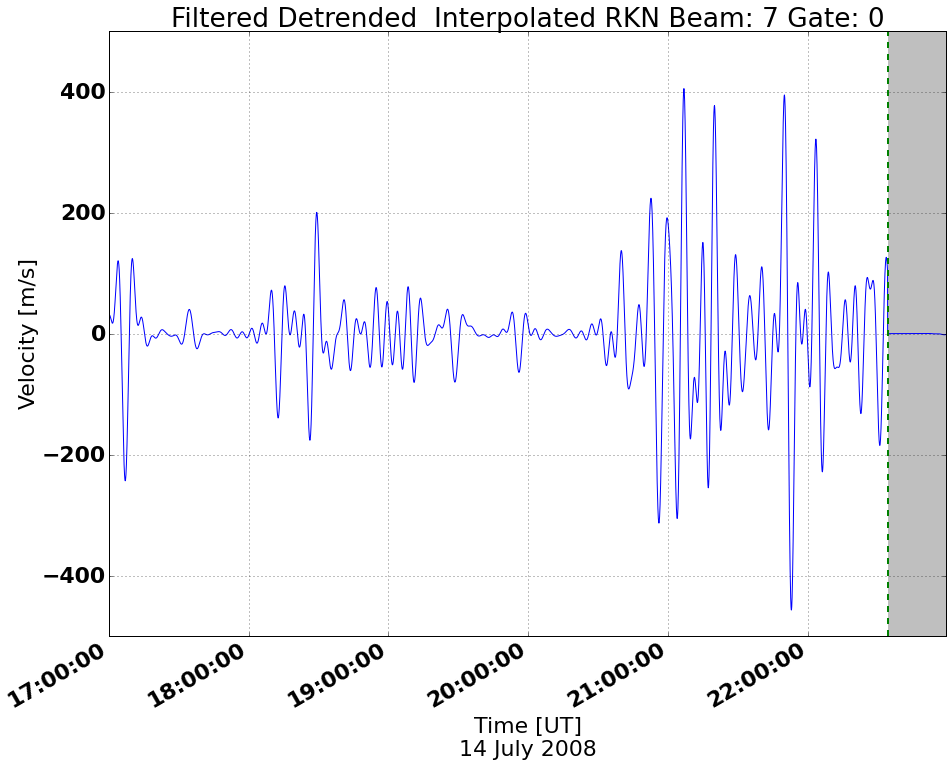

In [34]:
#Look at the filtered data.
rkn.filtered.plot(xmin=datetime.datetime(2008,7,14,17))

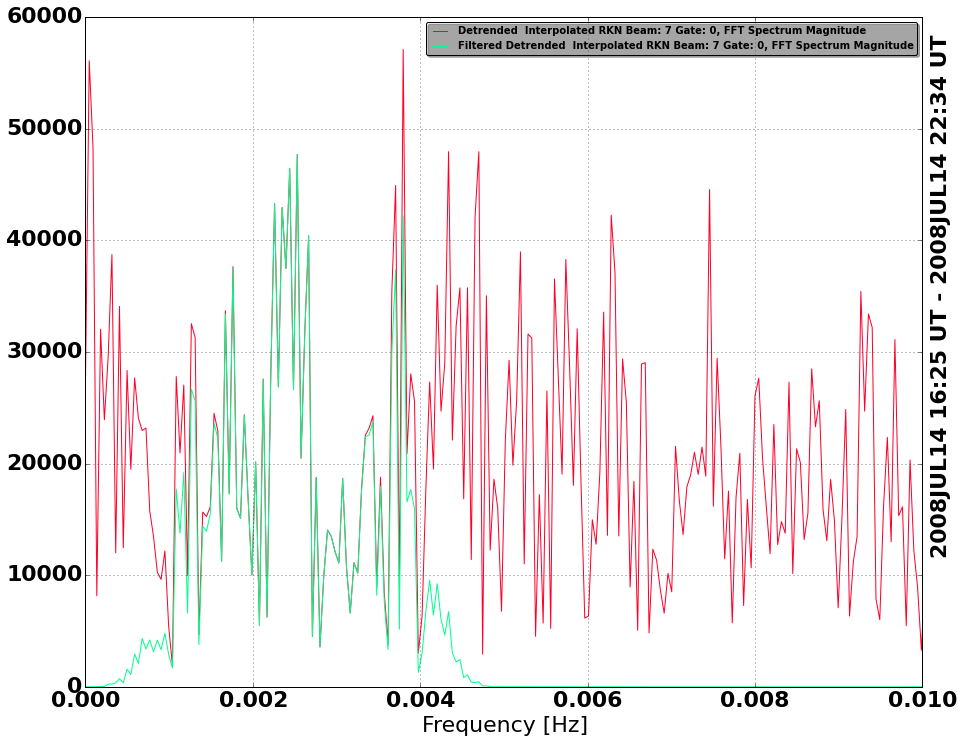

In [35]:
#Compare the filtered with the non-filetered spectrum.
a = signal.oplotfft([rkn.detrended,rkn.filtered],xmax=0.01)

# Overplotting Data

We can now compare the Rankin Inlet data with the satellite data.

In [36]:
#The truncate method removes any part of the signal that is outside of the validTimes.
goes10.filtered.truncate()
rkn.filtered.truncate()

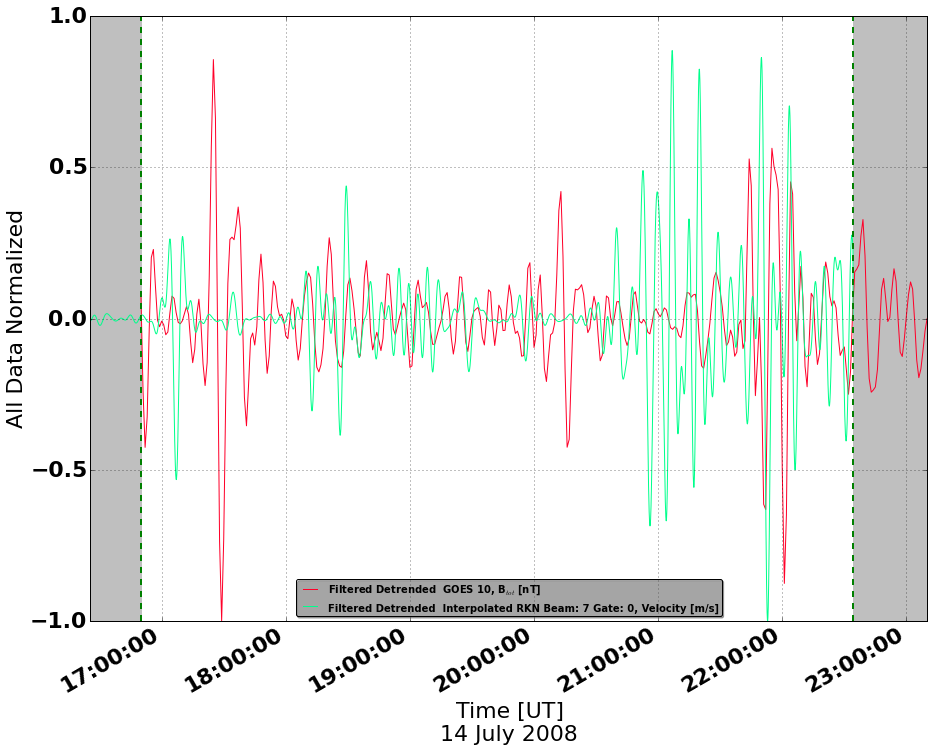

In [37]:
#Now we overplot the time series.  There is still some gray since the data sets do not overlap perfectly in time.
oplot = signal.oplot([goes10,rkn],normalize=True,legend_size=10)

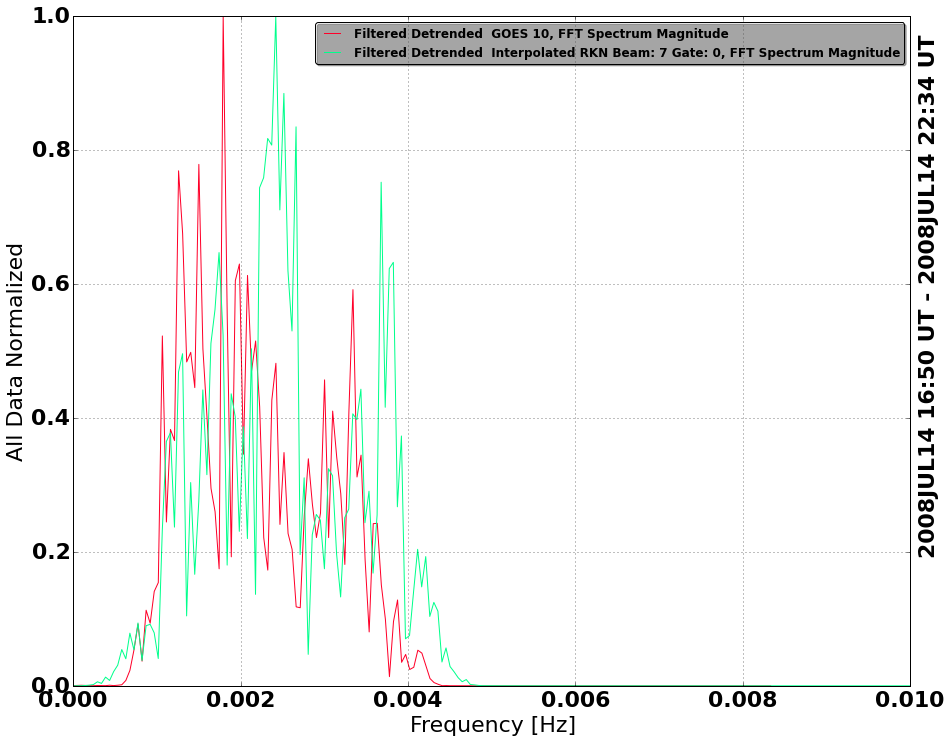

In [38]:
#We can also compare the spectra of the two signals.
oplot = signal.oplotfft([goes10,rkn],normalize=True,legend_size=12,xmax=0.010)

# Common Dtv Grid

In [39]:
#Finally, it is possible to place everything onto an identical time grid. The most restrictive range of validtimes and the highest time resolution is used.
signal.commonDtv([goes10.active,rkn.active])

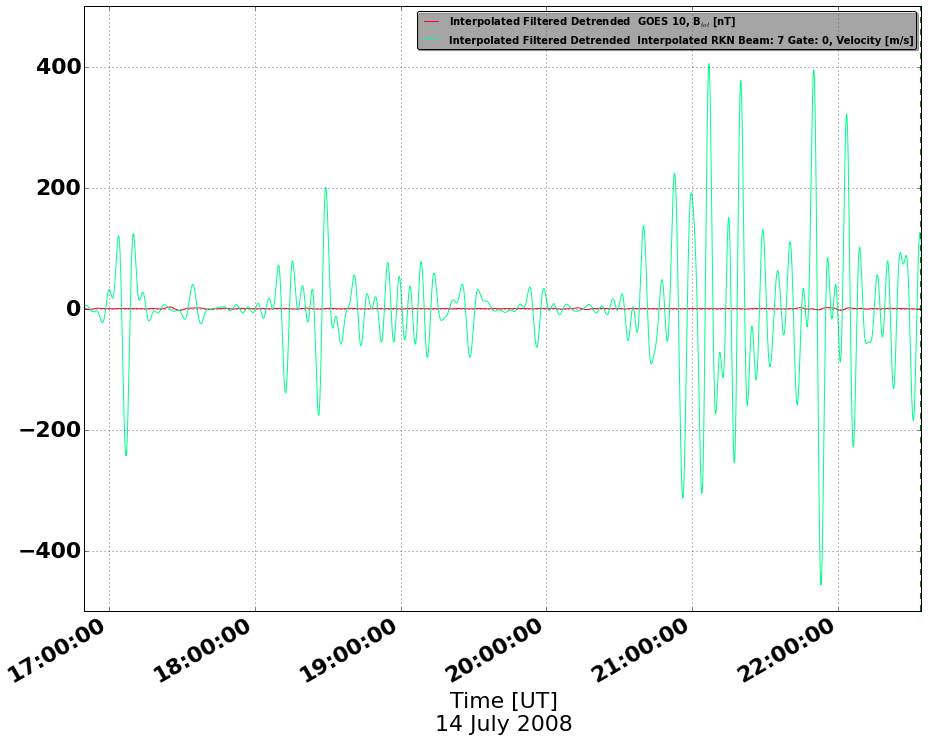

In [40]:
#Overplot two signals.  The amplitude of goes10 is small compare to rkn, so it is hard to really make anything out here.
#Note in the command below, no dataset is specified, so the active one is used by default.
signal.oplot([goes10,rkn])

In [41]:
#Don't forget we can look at the history of an object!
goes10.active.history

{datetime.datetime(2015, 3, 12, 1, 59, 48, 601049): 'Signal Object Created',
 datetime.datetime(2015, 3, 12, 1, 59, 53, 716269): 'Truncate: 2008JUL14 16:00 UT - 2008JUL15 00:00 UT',
 datetime.datetime(2015, 3, 12, 1, 59, 53, 754184): 'Linear detrend (scipy.signal.detrend)',
 datetime.datetime(2015, 3, 12, 1, 59, 55, 376582): 'Filter: blackman, Nyquist: 0.00833333333333 Hz, Cuttoff: [0.001, 0.004] Hz',
 datetime.datetime(2015, 3, 12, 2, 0, 40, 372369): 'Truncate: 2008JUL14 16:50 UT - 2008JUL14 23:10 UT',
 datetime.datetime(2015, 3, 12, 2, 0, 43, 67950): 'Interpolate: [2008-07-14 16:50:00 to 2008-07-14 22:34:12.300000] dt=0.3 s, Nyq=1.66666666667 Hz'}

In [42]:
rkn.active.history

{datetime.datetime(2015, 3, 12, 2, 0, 28, 763751): 'Signal Object Created',
 datetime.datetime(2015, 3, 12, 2, 0, 34, 834886): 'Truncate: 2008JUL14 16:00 UT - 2008JUL15 00:00 UT',
 datetime.datetime(2015, 3, 12, 2, 0, 34, 875974): 'Interpolate: [2008-07-14 16:00:24.512000 to 2008-07-14 22:59:09.512000] dt=3.0 s, Nyq=0.166666666667 Hz',
 datetime.datetime(2015, 3, 12, 2, 0, 35, 755835): 'Linear detrend (scipy.signal.detrend)',
 datetime.datetime(2015, 3, 12, 2, 0, 35, 862252): 'Filter: blackman, Nyquist: 0.166666666667 Hz, Cuttoff: [0.001, 0.004] Hz',
 datetime.datetime(2015, 3, 12, 2, 0, 40, 450470): 'Truncate: 2008JUL14 16:25 UT - 2008JUL14 22:34 UT',
 datetime.datetime(2015, 3, 12, 2, 0, 43, 267635): 'Interpolate: [2008-07-14 16:50:00 to 2008-07-14 22:34:12.300000] dt=0.3 s, Nyq=1.66666666667 Hz'}

## In the future, we can have cross correlation tools, too.  These commands are almost working, but not quite...

In [ ]:
#xcor = signal.xcor(rkn,goes10)

In [ ]:
#xcor.xcor.plot()